In [1]:
# All includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

from scipy import signal
feature_names = ['mean_x', 'mean_y', 'mean_z',
                    'rms_x', 'rms_y', 'rms_z',
                    'std_x', 'std_y', 'std_z',
                    'var_x', 'var_y', 'var_z',
                    'med_x', 'med_y', 'med_z',
                    'min_x', 'min_y', 'min_z',
                    'max_x', 'max_y', 'max_z']

target_names = ['Feeding', 'Lying', 'Standing', 'Lying down', 'Standing up', 'Normal Walking', 'Active walking']

def featuresFromBuffer(at, fs):
    feat = np.zeros(21)
    x = np.array(at.iloc[:,0], dtype=np.float64)   # x acceleration component
    y = np.array(at.iloc[:,1], dtype=np.float64)   # y
    z = np.array(at.iloc[:,2], dtype=np.float64)   # z

    # Average value in signal buffer for all three acceleration components (1 each)    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    
    # RMS value in signal buffer for all three acceleration components (1 each)
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms
    
    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std
    
    # Variance
    var = [np.var(i) for i in [x, y, z]]
    feat[9:12] = var
    
    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[12:15] = med
    
    # Range
    Range1 = [ np.amin(i) for i in [x, y, z]]    
    feat[15:18] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[18:21] = Range2

    return feat
    

In [2]:
# Import data

df = pd.read_excel('data.xlsx')

df = df.drop(columns=['Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23'])


In [3]:
# Prepare data

Feeding = df[['Feeding', 'Unnamed: 1', 'Unnamed: 2']]
Feeding = Feeding.dropna()
Feeding.index = pd.RangeIndex(len(Feeding.index))
Feeding = Feeding.drop(0)

Lying = df[['Lying', 'Unnamed: 4', 'Unnamed: 5']]
Lying = Lying.dropna()
Lying.index = pd.RangeIndex(len(Lying.index))
Lying = Lying.drop(0)

Standing = df[['Standing', 'Unnamed: 7', 'Unnamed: 8']]
Standing = Standing.dropna()
Standing.index = pd.RangeIndex(len(Standing.index))
Standing = Standing.drop(0)

Lying_down = df[['Lying down', 'Unnamed: 10', 'Unnamed: 11']]
Lying_down = Lying_down.dropna()
Lying_down.index = pd.RangeIndex(len(Lying_down.index))
Lying_down = Lying_down.drop(0)

Standing_up = df[['Standing up', 'Unnamed: 13', 'Unnamed: 14']]
Standing_up = Standing_up.dropna()
Standing_up.index = pd.RangeIndex(len(Standing_up.index))
Standing_up = Standing_up.drop(0)

Normal_walking = df[['Normal walking', 'Unnamed: 16', 'Unnamed: 17']]
Normal_walking = Normal_walking.dropna()
Normal_walking.index = pd.RangeIndex(len(Normal_walking.index))
Normal_walking = Normal_walking.drop(0)

Active_walking = df[['Active walking', 'Unnamed: 19', 'Unnamed: 20']]
Active_walking = Active_walking.dropna()
Active_walking.index = pd.RangeIndex(len(Active_walking.index))
Active_walking = Active_walking.drop(0)


In [4]:
window_size = 16
stride = 6

X_feeding_train = [Feeding[i:i+window_size] for i in range(0, int(len(Feeding)*0.6), stride) if i+window_size<=int(len(Feeding))]
X_feeding_test = [Feeding[i:i+window_size] for i in range(int(len(Feeding)*0.6), len(Feeding), stride) if i+window_size<=len(Feeding)]

X_lying_train = [Lying[i:i+window_size] for i in range(0, int(len(Lying)*0.6), stride) if i+window_size<=int(len(Lying))]
X_lying_test = [Lying[i:i+window_size] for i in range(int(len(Lying)*0.6), len(Lying), stride) if i+window_size<=len(Lying)]

X_standing_train = [Standing[i:i+window_size] for i in range(0, int(len(Standing)*0.6), stride) if i+window_size<=int(len(Standing))]
X_standing_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*0.6), len(Standing), stride) if i+window_size<=len(Standing)]

X_lydown_train = [Lying_down[i:i+window_size] for i in range(0, int(len(Lying_down)*0.6), stride) if i+window_size<=int(len(Lying_down))]
X_lydown_test = [Lying_down[i:i+window_size] for i in range(int(len(Lying_down)*0.6), len(Lying_down), stride) if i+window_size<=len(Lying_down)]

X_standup_train = [Standing_up[i:i+window_size] for i in range(0, int(len(Standing_up)*0.6), stride) if i+window_size<=int(len(Standing_up))]
X_standup_test = [Standing_up[i:i+window_size] for i in range(int(len(Standing_up)*0.6), len(Standing_up), stride) if i+window_size<=len(Standing_up)]

X_normalw_train = [Normal_walking[i:i+window_size] for i in range(0, int(len(Normal_walking)*0.6), stride) if i+window_size<=int(len(Normal_walking))]
X_normalw_test = [Normal_walking[i:i+window_size] for i in range(int(len(Normal_walking)*0.6), len(Normal_walking), stride) if i+window_size<=len(Normal_walking)]

X_activew_train = [Active_walking[i:i+window_size] for i in range(0, int(len(Active_walking)*0.6), stride) if i+window_size<=int(len(Active_walking))]
X_activew_test = [Active_walking[i:i+window_size] for i in range(int(len(Active_walking)*0.6), len(Active_walking), stride) if i+window_size<=len(Active_walking)]

print('X_feeding_train: ', len(X_feeding_train))
print('X_feeding_test: ', len(X_feeding_test))



print('X_lying_train: ', len(X_lying_train))
print('X_lying_test: ', len(X_lying_test))


print('X_standing_train: ', len(X_standing_train))
print('X_standing_test: ', len(X_standing_test))


print('X_lying_down_train: ', len(X_lydown_train))
print('X_lying_down_test: ', len(X_lydown_test))


print('X_stand-up_train: ', len(X_standup_train))
print('X_stand-up_test: ', len(X_standup_test))


print('X_normalw_train: ', len(X_normalw_train))
print('X_normalw_test: ', len(X_normalw_test))


print('X_activew_train: ', len(X_activew_train))
print('X_activew_test: ', len(X_activew_test))

print('Total: \n')
print('Train: ', len(X_feeding_train)+len(X_lying_train)+len(X_standing_train)+len(X_lydown_train)+
     len(X_standup_train)+len(X_normalw_train)+len(X_activew_train))
print('Train: ', len(X_feeding_test)+len(X_lying_test)+len(X_standing_test)+len(X_lydown_test)+
     len(X_standup_test)+len(X_normalw_test)+len(X_activew_test))

X_feeding_train:  369
X_feeding_test:  244
X_lying_train:  440
X_lying_test:  291
X_standing_train:  272
X_standing_test:  179
X_lying_down_train:  197
X_lying_down_test:  129
X_stand-up_train:  183
X_stand-up_test:  120
X_normalw_train:  444
X_normalw_test:  294
X_activew_train:  311
X_activew_test:  205
Total: 

Train:  2216
Train:  1462


In [5]:
#Catch 'em all

my_train_data = []
my_train_lable = []

my_test_data = []
my_test_lable = []

for acts in X_feeding_train:
    my_train_data.append(acts)
    my_train_lable.append(0)

for acts in X_lying_train:
    my_train_data.append(acts)
    my_train_lable.append(1)
    
for acts in X_standing_train:
    my_train_data.append(acts)
    my_train_lable.append(2)
    
for acts in X_lydown_train:
    my_train_data.append(acts)
    my_train_lable.append(3)
    
for acts in X_standup_train:
    my_train_data.append(acts)
    my_train_lable.append(4)


for acts in X_normalw_train:
    my_train_data.append(acts)
    my_train_lable.append(5)

for acts in X_activew_train:
    my_train_data.append(acts)
    my_train_lable.append(6)
    
print('my-train-data\'s length: ', len(my_train_data) )
print('my-train-lable\'s length: ', len(my_train_lable) )

#Catch 'em all

for acts in X_feeding_test:
    my_test_data.append(acts)
    my_test_lable.append(0)

for acts in X_lying_test:
    my_test_data.append(acts)
    my_test_lable.append(1)
    
for acts in X_standing_test:
    my_test_data.append(acts)
    my_test_lable.append(2)
    
for acts in X_lydown_test:
    my_test_data.append(acts)
    my_test_lable.append(3)
    
for acts in X_standup_test:
    my_test_data.append(acts)
    my_test_lable.append(4)

for acts in X_normalw_test:
    my_test_data.append(acts)
    my_test_lable.append(5)


for acts in X_activew_test:
    my_test_data.append(acts)
    my_test_lable.append(6)
    
print('my-test-data\'s length: ', len(my_test_data) )
print('my-test-lable\'s length: ', len(my_test_lable) )

my-train-data's length:  2216
my-train-lable's length:  2216
my-test-data's length:  1462
my-test-lable's length:  1462


In [6]:
train_features = []
test_features = []
for action in my_train_data:
    feat = featuresFromBuffer(action, 1)
    train_features.append(feat)

for action in my_test_data:
    feat = featuresFromBuffer(action, 1)
    test_features.append(feat)
    
len(train_features)
len(test_features)

2216

1462

In [7]:
# beginning of classification:

print("Decision Tree stuffs:")
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, my_train_lable)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'
     .format(clf2.score(train_features, my_train_lable)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
     .format(clf2.score(test_features, my_test_lable)))



print("\n\nDecision Tree DTBD stuffs:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.5, max_depth=3, n_estimators=100).fit(train_features, my_train_lable)

print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, my_train_lable)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, my_test_lable)))


print("\n\nSVM stuffs:")
this_C = 100
clf = SVC(C=this_C).fit(train_features, my_train_lable)
print("Accuracy on training set: {:.2f}".format(clf.score(train_features, my_train_lable)))
print("Accuracy on test set: {:.2f}".format(clf.score(test_features, my_test_lable)))


print('\n\n Random Forests stuffs: ')
from sklearn.ensemble import RandomForestClassifier
clf5 = RandomForestClassifier(n_estimators=25, random_state=0).fit(train_features, my_train_lable)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf5.score(train_features, my_train_lable)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf5.score(test_features, my_test_lable)))


print('\n\n KNeighbor stuffs: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(train_features, my_train_lable)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, my_train_lable)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, my_test_lable)))

Decision Tree stuffs:
Accuracy of Decision Tree classifier on training set: 0.771
Accuracy of Decision Tree classifier on test set: 0.789


Decision Tree DTBD stuffs:
Accuracy of GBDT classifier on training set: 0.959
Accuracy of GBDT classifier on test set: 0.856


SVM stuffs:
Accuracy on training set: 0.87
Accuracy on test set: 0.80


 Random Forests stuffs: 
Accuracy of RF classifier on training set: 0.958
Accuracy of RF classifier on test set: 0.847


 KNeighbor stuffs: 


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Accuracy of K-NN classifier on training set: 0.89
Accuracy of K-NN classifier on test set: 0.84


Text(0.5,1,'Decision Tree \nAccuracy:0.856')

Text(114,0.5,'True label')

Text(0.5,69,'Predicted label')

             precision    recall  f1-score   support

          0       0.80      0.92      0.85       244
          1       1.00      1.00      1.00       291
          2       0.86      0.67      0.75       179
          3       0.52      0.52      0.52       129
          4       0.48      0.47      0.47       120
          5       0.98      1.00      0.99       294
          6       0.96      0.98      0.97       205

avg / total       0.86      0.86      0.85      1462



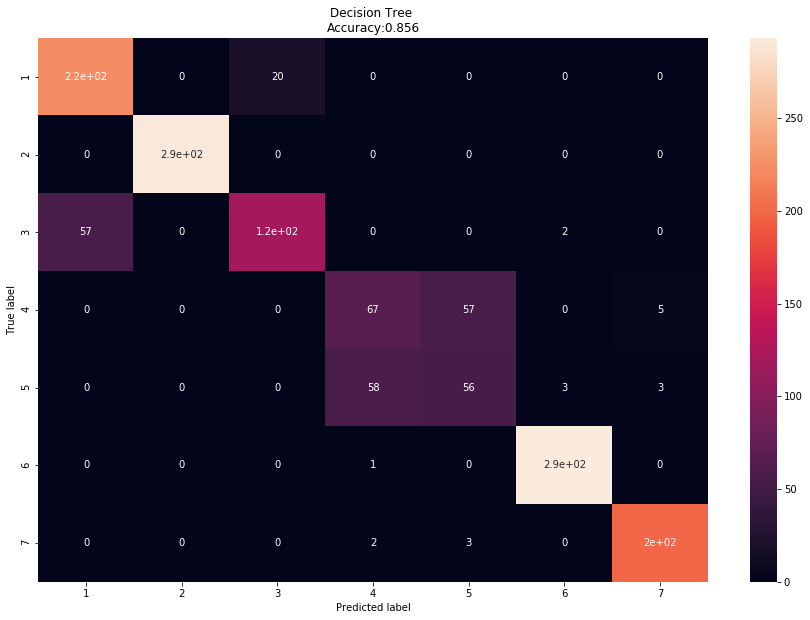

In [8]:
# make color
import seaborn as sns
from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# confusion matrices:
predicted = clf1.predict(test_features)

confusion_test = confusion_matrix(my_test_lable, predicted)

df_cm = pd.DataFrame(confusion_test,
                    index = [i for i in range(1, 8)], columns = [i for i in range(1, 8)])


plt.figure(figsize=(15,10))

sns.heatmap(df_cm, annot=True)

plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(my_test_lable, 
                                                                       predicted)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

print(classification_report(my_test_lable, predicted))
# Accuracy is calculated follow vertically
# for example:
# accuracy for the 3rd status: 58/(58+23)

#print('Feature importances: {}'.format(clf.feature_importances_))

7


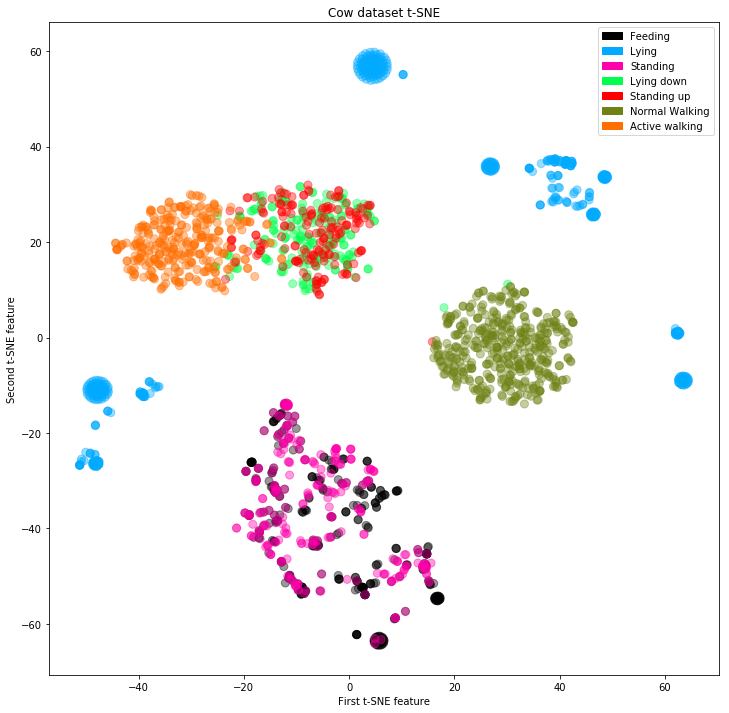

In [9]:
# Visualisation: t-sne

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    print(num_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#000000', '#00AAFF', '#FF00AA', '#00FF4C', '#ff0000', '#6e8216', '#ff6e00']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels)
    #f = plt.figure(figsize=(10, 10))
    plt.figure(figsize=(12, 12))

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, lw=1)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    
    plt.xlabel('First t-SNE feature')
    plt.ylabel('Second t-SNE feature')
    plt.title('Cow dataset t-SNE');

    plt.show()


X_visual = train_features
y_visual = np.array(my_train_lable, dtype=np.uint8)

n_samples = 300
n_components = 2
perplexity = 30
RS = 1000

from sklearn.manifold import TSNE

X_tsne = TSNE(random_state=RS).fit_transform(X_visual)

plot_labelled_scatter(X_tsne, y_visual,['Feeding', 'Lying', 'Standing', 'Lying down', 'Standing up', 'Normal Walking', 'Active walking'])
